## imports

In [7]:
import os
import sys
import faiss
import pretty_midi
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from src.utils import basename
from src.utils.midi import upsample_piano_roll
from src.ml.specdiff.model import SpectrogramDiffusion

## setup

In [8]:
np.random.seed(0)

FAISS_INDEX_PATH = "/media/scratch/sageev-midi/20250410/specdiff.faiss"
DATA_DIR = "/media/scratch/sageev-midi/20250410/augmented"
pf_augmentations = os.path.join("outputs", "augmentations")
os.makedirs(pf_augmentations, exist_ok=True)

faiss_index = faiss.read_index(FAISS_INDEX_PATH)
specdiff = SpectrogramDiffusion(verbose=True)

all_files = glob(os.path.join(DATA_DIR, "*.mid"))
base_files = glob(os.path.join(DATA_DIR, "*t00s00.mid"))
all_files.sort()

chosen_files = np.random.choice(base_files, size=3, replace=False)

04-19 15:00:45.251266 spcdif: initializing spectrogram diffusion model                                  ]8;id=242983;file:///home/finlay/disklavier/src/ml/specdiff/model.py\model.py]8;;\:]8;id=578737;file:///home/finlay/disklavier/src/ml/specdiff/model.py#53\53]8;;\

04-19 15:00:47.164167 spcdif: model initialization complete                                             ]8;id=658237;file:///home/finlay/disklavier/src/ml/specdiff/model.py\model.py]8;;\:]8;id=129870;file:///home/finlay/disklavier/src/ml/specdiff/model.py#79\79]8;;\

## helper functions

In [9]:
def compute_average_pitch(pm_object):
    """
    compute the average pitch of all notes in a prettymidi object.

    parameters
    ----------
    pm_object : pretty_midi.PrettyMIDI
        the midi object.

    returns
    -------
    float
        the average pitch, or 0.0 if no notes are present.
    """
    total_pitch = 0.0
    note_count = 0
    for instrument in pm_object.instruments:
        if not instrument.is_drum:
            for note in instrument.notes:
                total_pitch += note.pitch
                note_count += 1
    if note_count == 0:
        return 0.0
    return total_pitch / note_count


def plot_similarity_matrix(matrix, title, ax):
    """
    plot a similarity matrix using seaborn heatmap.

    parameters
    ----------
    matrix : np.ndarray
        the similarity matrix.
    title : str
        the title for the plot.
    ax : matplotlib.axes.Axes
        the axes object to plot on.
    """
    # Using seaborn for better annotation and color mapping
    sns.heatmap(
        matrix,
        ax=ax,
        cmap="crest",
        annot=True,
        fmt=".2f",
        vmin=0,
        vmax=1,
        square=True,
        cbar_kws={"shrink": 0.8},
    )
    ax.set_title(title)
    ax.set_xlabel("midi object index")
    ax.set_ylabel("midi object index")
    # Ensure ticks are integers 0 to 12
    tick_labels = [str(i) for i in range(matrix.shape[0])]
    ax.set_xticks(np.arange(matrix.shape[0]) + 0.5)
    ax.set_yticks(np.arange(matrix.shape[0]) + 0.5)
    ax.set_xticklabels(tick_labels)
    ax.set_yticklabels(tick_labels, rotation=0)


def plot_piano_roll(pm: pretty_midi.PrettyMIDI, filename: str):
    """
    plot the piano roll and chroma histograms of a prettymidi object.

    parameters
    ----------
    pm : pretty_midi.PrettyMIDI
        the midi object.
    filename : str
        base name for title.
    """
    # create a 2x2 grid spec
    fig = plt.figure(figsize=(12, 8))
    gs = fig.add_gridspec(2, 2, height_ratios=[2, 1])  # make piano roll taller

    # piano roll spanning top row
    ax_pr = fig.add_subplot(gs[0, :])
    pr = pm.get_piano_roll(fs=100)
    ax_pr.imshow(upsample_piano_roll(pr), aspect="auto", cmap="gray_r")
    ax_pr.set_title(f"piano roll: {filename}")
    ax_pr.set_xlabel("time (frames, fs=100)")
    ax_pr.set_yticks([])

    # transpose +6 for the second histogram (create a copy first!)
    pm_transposed = pretty_midi.PrettyMIDI()
    for inst in pm.instruments:
        # create a new instrument to avoid modifying the original
        transposed_inst = pretty_midi.Instrument(
            program=inst.program, is_drum=inst.is_drum, name=f"{inst.name} +6st"
        )
        for note in inst.notes:
            transposed_note = pretty_midi.Note(
                velocity=note.velocity,
                pitch=note.pitch + 6,
                start=note.start,
                end=note.end,
            )
            transposed_inst.notes.append(transposed_note)
        pm_transposed.instruments.append(transposed_inst)

    # chroma histogram (original) - bottom left
    ax_hist1 = fig.add_subplot(gs[1, 0])
    chroma_orig = compute_chroma_histogram(
        pm, normalize=False
    )  # use counts for bar chart
    chroma_labels = ["c", "c#", "d", "d#", "e", "f", "f#", "g", "g#", "a", "a#", "b"]
    ax_hist1.bar(range(12), chroma_orig)
    ax_hist1.set_xticks(range(12))
    ax_hist1.set_xticklabels(chroma_labels)
    ax_hist1.set_title("chroma histogram (original)")
    ax_hist1.set_ylabel("note count")

    # chroma histogram (transposed +6) - bottom right
    ax_hist2 = fig.add_subplot(gs[1, 1])
    chroma_transposed = compute_chroma_histogram(pm_transposed, normalize=False)
    ax_hist2.bar(range(12), chroma_transposed)
    ax_hist2.set_xticks(range(12))
    ax_hist2.set_xticklabels(chroma_labels)
    ax_hist2.set_title("chroma histogram (+6 semitones)")
    ax_hist2.set_ylabel("note count")

    plt.tight_layout()
    plt.show()

## go


processing: 20240121-070-01_0240-0247_t00s00


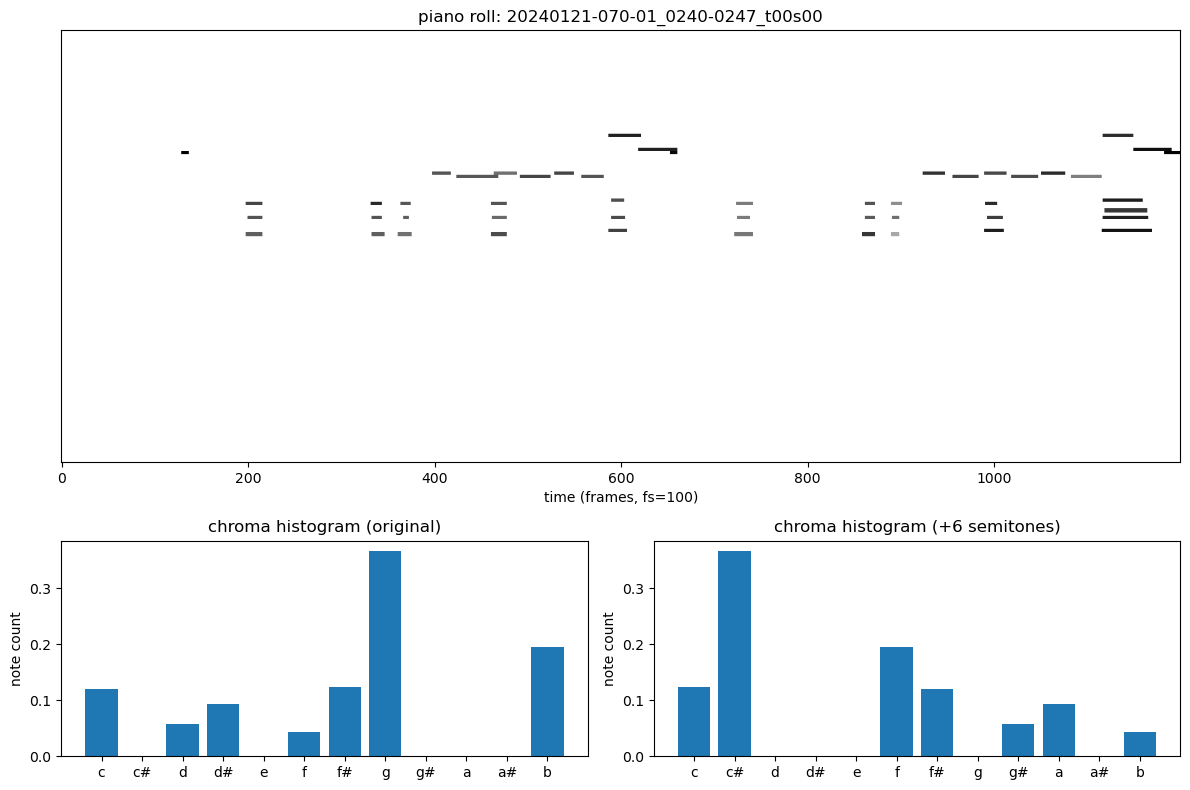

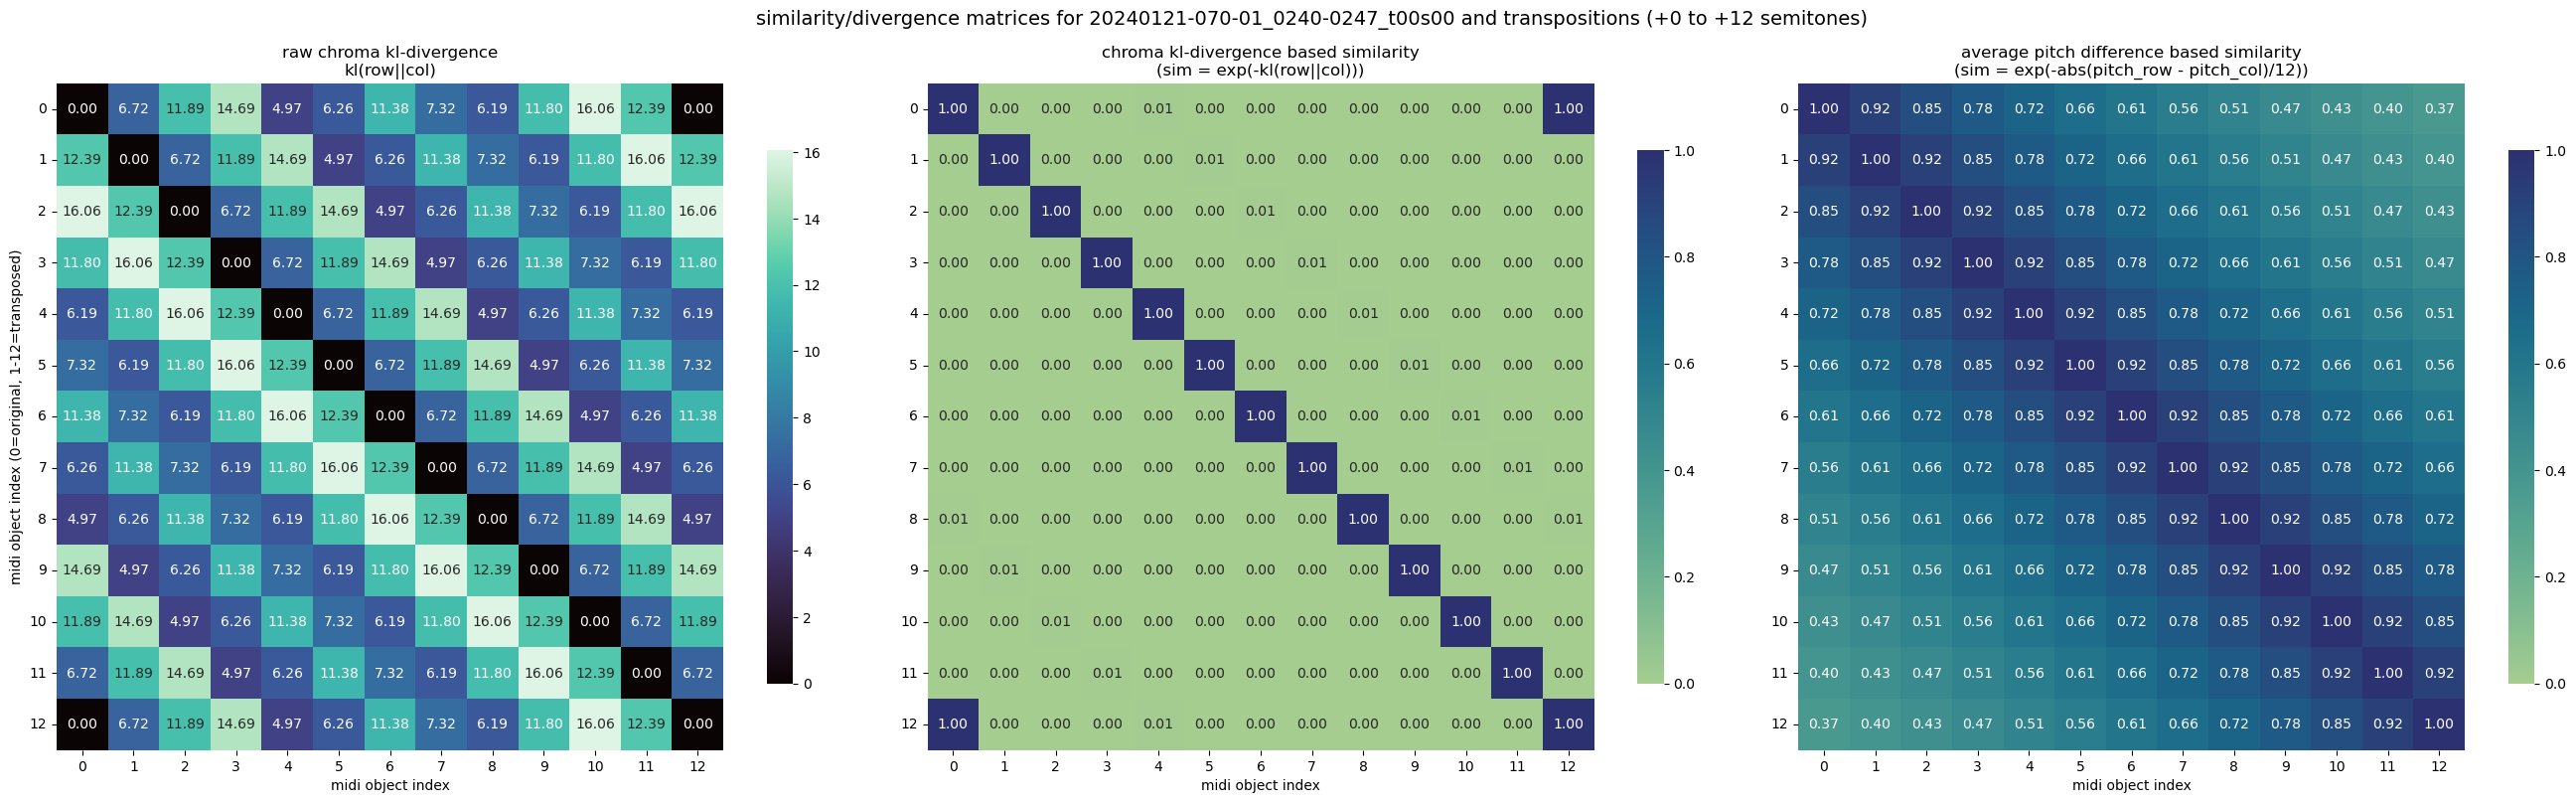

processing: 20240511-088-01_0229-0235_t00s00


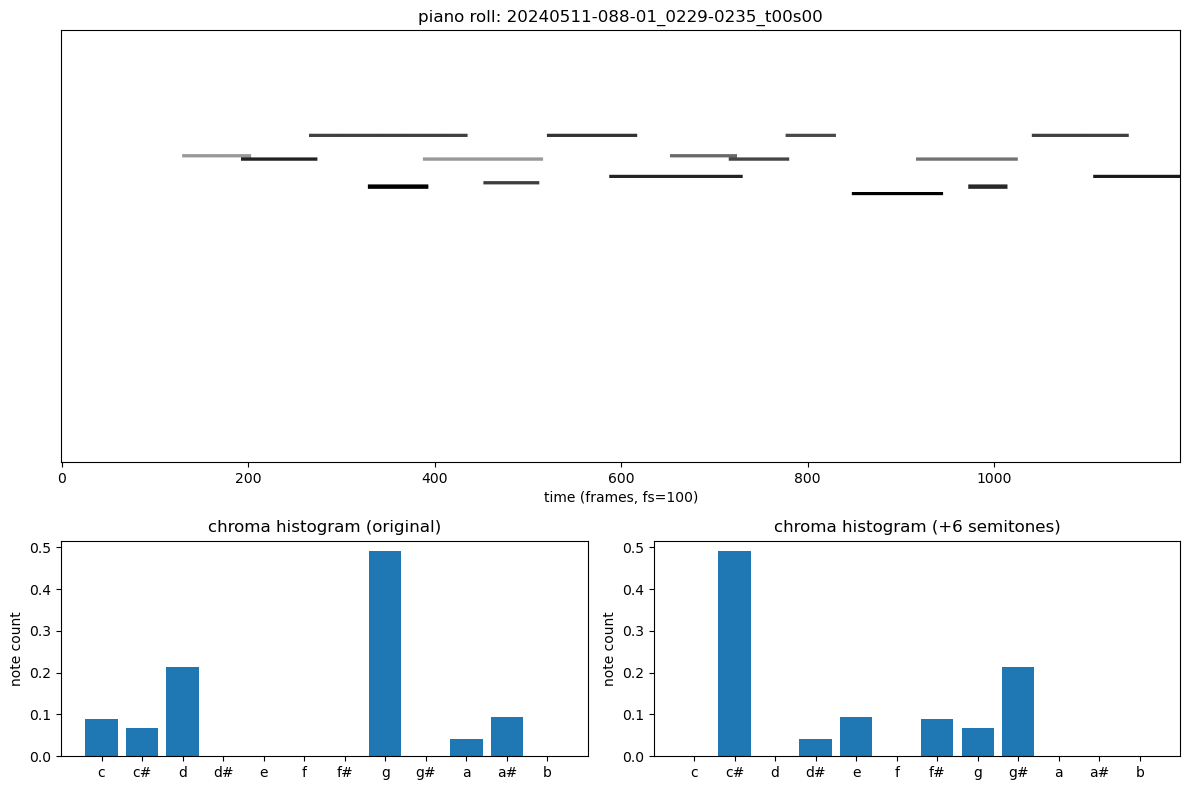

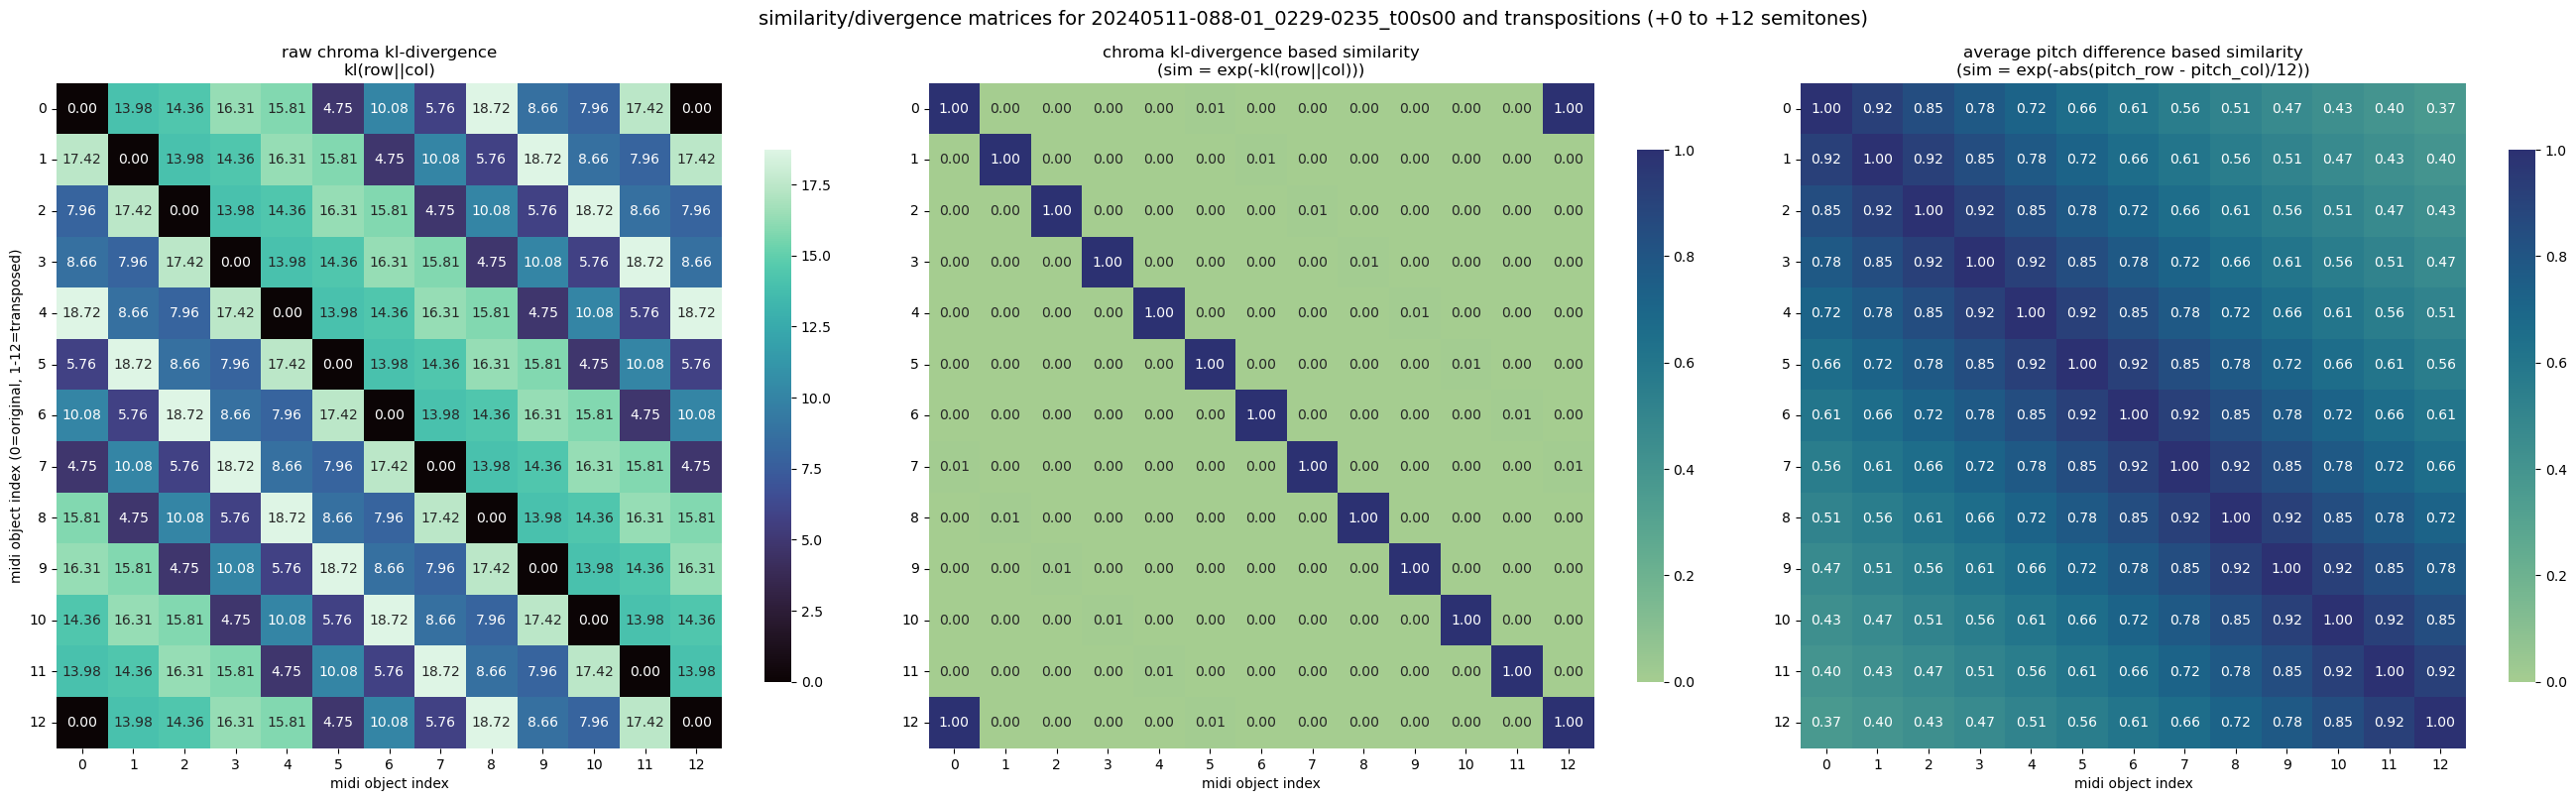

processing: 20240312-080-05_0054-0060_t00s00


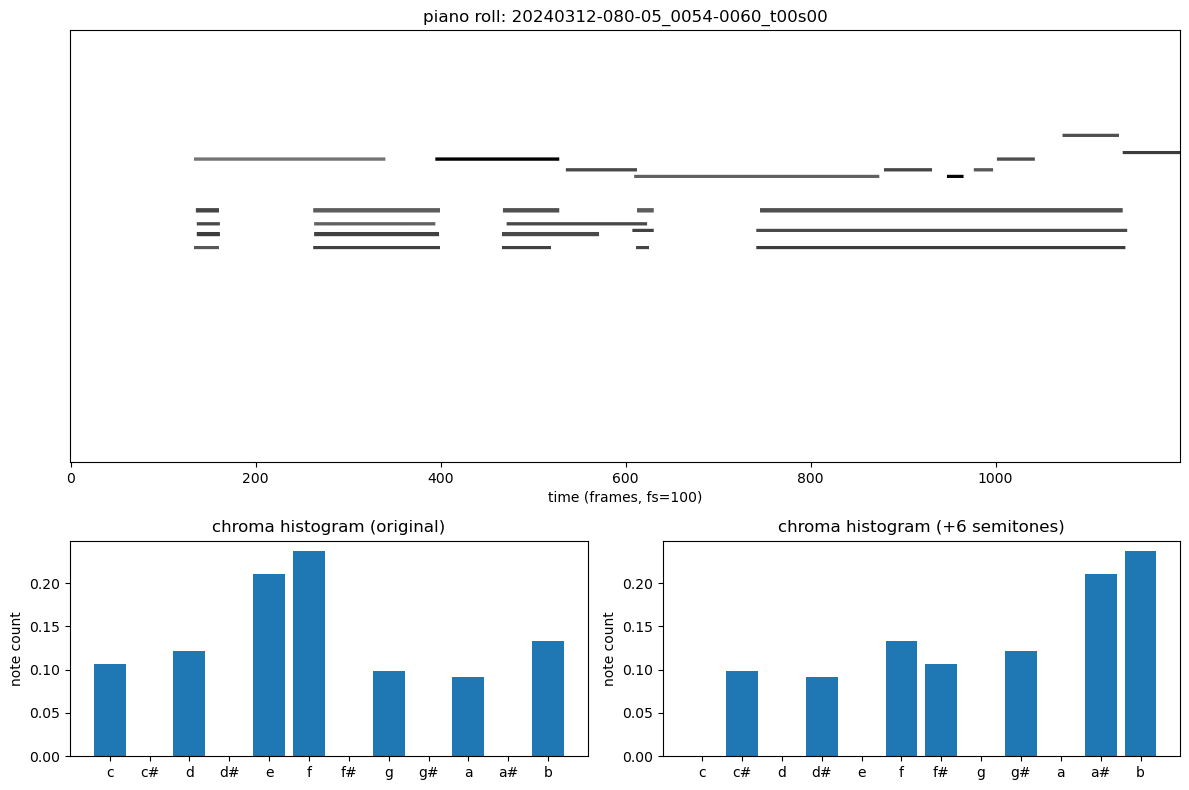

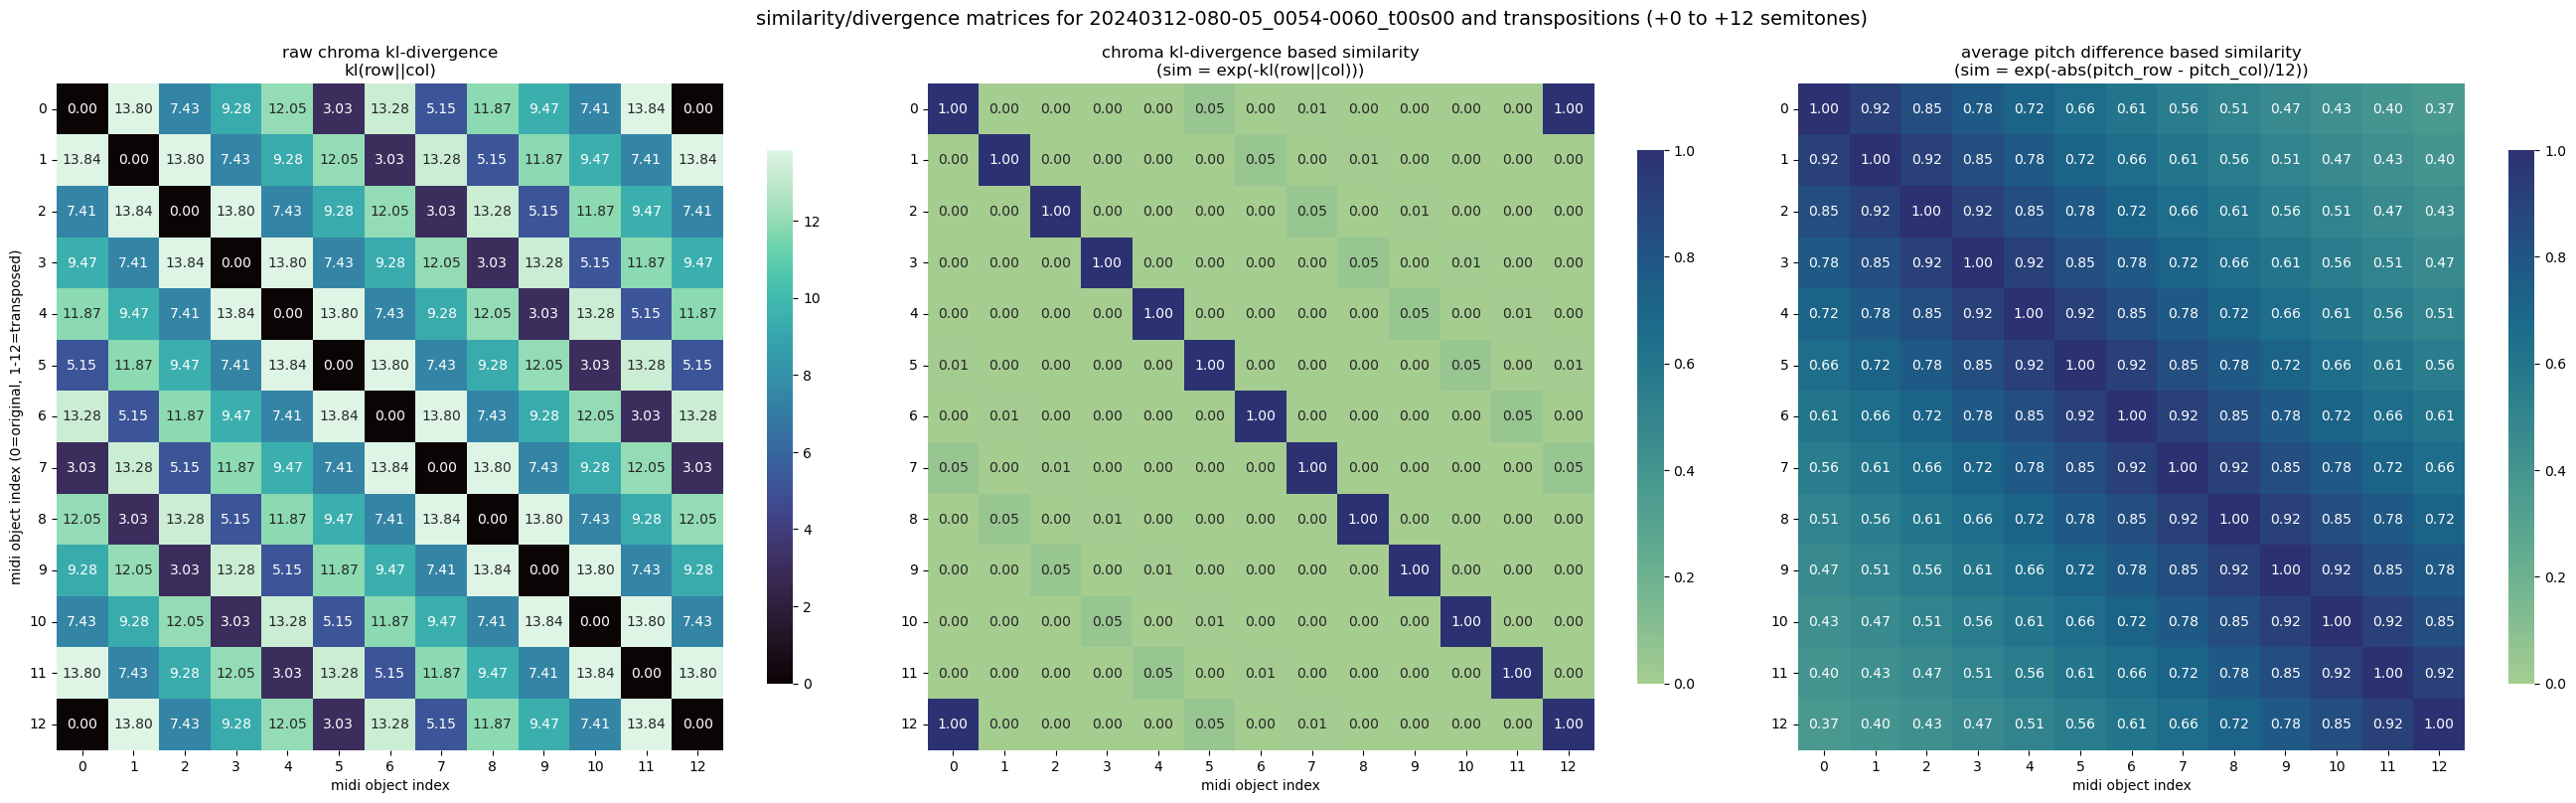

In [11]:
file_data = {}
for chosen_file in chosen_files:
    print(f"processing: {basename(chosen_file)}")
    try:
        original_pm = pretty_midi.PrettyMIDI(chosen_file)
    except Exception as e:
        print(f"[red]error loading {chosen_file}: {e}[/red]")
        continue

    plot_piano_roll(original_pm, basename(chosen_file))

    transposed_midis = [original_pm]
    for i in range(1, 13):  # transpose +1 to +12 semitones
        transposed_pm = pretty_midi.PrettyMIDI(chosen_file)  # reload original
        for instrument in transposed_pm.instruments:
            if not instrument.is_drum:
                for note in instrument.notes:
                    note.pitch += i
        transposed_midis.append(transposed_pm)

    num_midis = len(transposed_midis)
    sim_chroma = np.zeros((num_midis, num_midis))
    sim_pitch = np.zeros((num_midis, num_midis))
    kl_chroma = np.full((num_midis, num_midis), np.inf)  # store raw kl divergence

    # precompute histograms and average pitches
    chroma_histograms = [
        pm.get_pitch_class_histogram(True, True) for pm in transposed_midis
    ]
    average_pitches = [compute_average_pitch(pm) for pm in transposed_midis]

    epsilon_kl = 1e-10  # small value for kl divergence

    for i in range(num_midis):
        for j in range(num_midis):
            # chroma similarity (using kl divergence)
            hist_i = chroma_histograms[i]
            hist_j = chroma_histograms[j]

            # kl divergence requires positive probabilities summing to 1
            sum_i = np.sum(hist_i)
            sum_j = np.sum(hist_j)

            if i == j:
                sim_chroma[i, j] = 1.0
                kl_chroma[i, j] = 0.0  # kl is 0 for identical distributions
            elif sum_i > 0 and sum_j > 0:
                # use the already normalized histograms if normalize=True was used
                p = hist_i + epsilon_kl
                q = hist_j + epsilon_kl
                # re-normalize after adding epsilon to maintain probability distribution properties
                p /= np.sum(p)
                q /= np.sum(q)

                kl_ij = entropy(p, q)  # kl(p || q)
                kl_chroma[i, j] = kl_ij  # store raw kl
                # using exp(-kl) for similarity. lower kl -> higher similarity. kl=0 -> sim=1. kl=inf -> sim=0.
                sim_chroma[i, j] = np.exp(-kl_ij)
            else:
                sim_chroma[i, j] = 0.0
                # kl_chroma remains np.inf (set during initialization) if histograms are empty

            # average pitch similarity
            pitch_i = average_pitches[i]
            pitch_j = average_pitches[j]
            pitch_diff = abs(pitch_i - pitch_j)
            # similarity decreases exponentially with pitch difference
            # scaling factor adjustment: use 12.0 so similarity is exp(-1) ~ 0.37 for octave diff
            sim_pitch[i, j] = np.exp(-pitch_diff / 12.0)

    # plotting
    fig, axes = plt.subplots(
        1, 3, figsize=(27, 8)
    )  # Changed to 1x3 layout, increased size
    fig.suptitle(
        f"similarity/divergence matrices for {basename(chosen_file)} and transpositions (+0 to +12 semitones)",
        fontsize=14,
    )

    # plot raw kl divergence matrix
    sns.heatmap(
        kl_chroma,
        ax=axes[0],
        cmap="mako",
        annot=True,
        fmt=".2f",
        square=True,
        cbar_kws={"shrink": 0.8},
    )
    axes[0].set_title("raw chroma kl-divergence\nkl(row||col)")
    axes[0].set_xlabel("midi object index")
    axes[0].set_ylabel("midi object index (0=original, 1-12=transposed)")
    tick_labels = [str(i) for i in range(num_midis)]
    axes[0].set_xticks(np.arange(num_midis) + 0.5)
    axes[0].set_yticks(np.arange(num_midis) + 0.5)
    axes[0].set_xticklabels(tick_labels)
    axes[0].set_yticklabels(tick_labels, rotation=0)

    # plot similarity matrices (using the existing function)
    plot_similarity_matrix(
        sim_chroma,
        "chroma kl-divergence based similarity\n(sim = exp(-kl(row||col)))",
        axes[1],  # plot in the second axes
    )
    plot_similarity_matrix(
        sim_pitch,
        "average pitch difference based similarity\n(sim = exp(-abs(pitch_row - pitch_col)/12))",
        axes[2],  # plot in the third axes
    )

    # Adjust labels for the other plots if needed (ylabel only needed on the first plot now)
    axes[1].set_ylabel("")
    axes[2].set_ylabel("")

    plt.tight_layout(rect=(0, 0.03, 1, 0.95))  # adjust layout to prevent title overlap
    plt.show()
    plt.close(fig)